(<Figure size 900x1000 with 1 Axes>, <Axes: >)

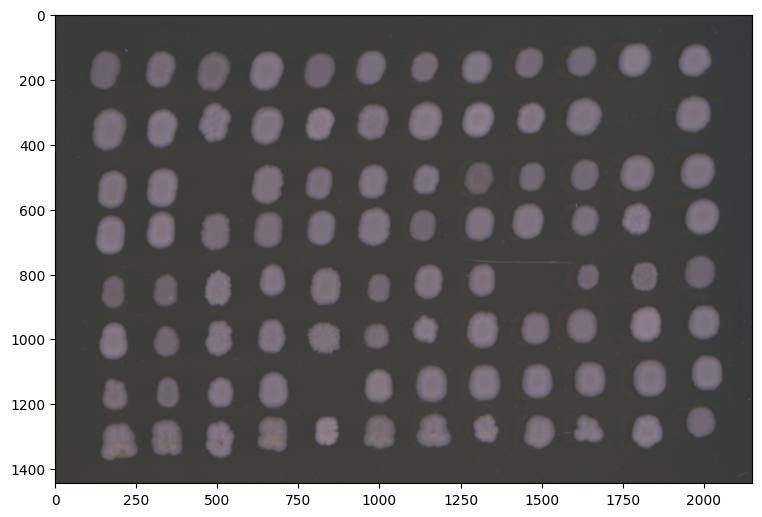

In [1]:
from phenotypic import GridImage

from phenotypic.data import load_plate_72hr

plate_image = GridImage(load_plate_72hr())
plate_image.show()

In [2]:
from pympler import asizeof

print(f'Array size: {asizeof.asizeof(load_plate_72hr()) / 1000000} mbytes')
print(f'Phenotypic.GridImage: {asizeof.asizeof(plate_image) / 1000000} mbytes')
print(f'Ratio: {asizeof.asizeof(plate_image) / asizeof.asizeof(load_plate_72hr())}')

Array size: 9.31396 mbytes
Phenotypic.GridImage: 34.169144 mbytes
Ratio: 3.668594668647922


In [3]:
total_data_footprint = 0
for data_key, data_value in plate_image._data.__dict__.items():
    print(
        f'{data_key} | {data_value.dtype}: {asizeof.asizeof(data_value) / 1000000} mbytes | shape: {data_value.shape} | fold-increase: {asizeof.asizeof(data_value) / asizeof.asizeof(load_plate_72hr())}')
    total_data_footprint += asizeof.asizeof(data_value)
print(f'Total data footprint: {total_data_footprint / 1000000} mbytes')
print(f'Class overhead: {asizeof.asizeof(plate_image) / 1000000 - total_data_footprint / 1000000}')

array | uint8: 9.31396 mbytes | shape: (1444, 2150, 3) | fold-increase: 1.0
matrix | uint32: 12.41856 mbytes | shape: (1444, 2150) | fold-increase: 1.3333276071617228
enh_matrix | uint32: 12.41856 mbytes | shape: (1444, 2150) | fold-increase: 1.3333276071617228
sparse_object_map | uint16: 0.01008 mbytes | shape: (1444, 2150) | fold-increase: 0.0010822464343845154
Total data footprint: 34.16116 mbytes
Class overhead: 0.007984000000000435


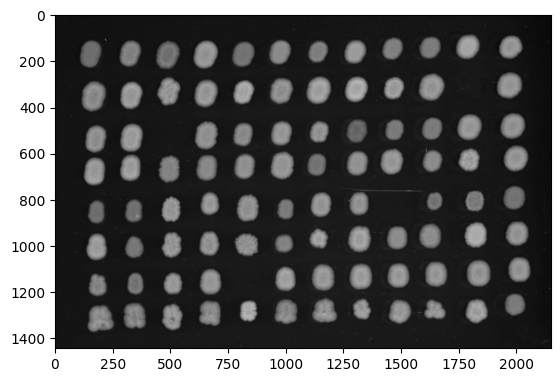

In [4]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
fig, ax = plt.subplots()
ax.grid(False)
ax.imshow(rgb2gray(plate_image.array[:]), cmap='gray')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

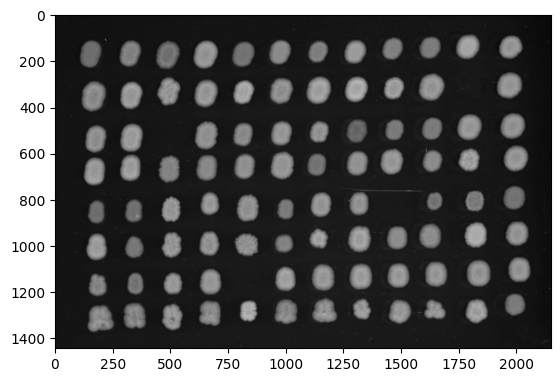

In [5]:
plate_image.matrix.show()

(1444, 2150)


(<Figure size 900x1000 with 1 Axes>, <Axes: >)

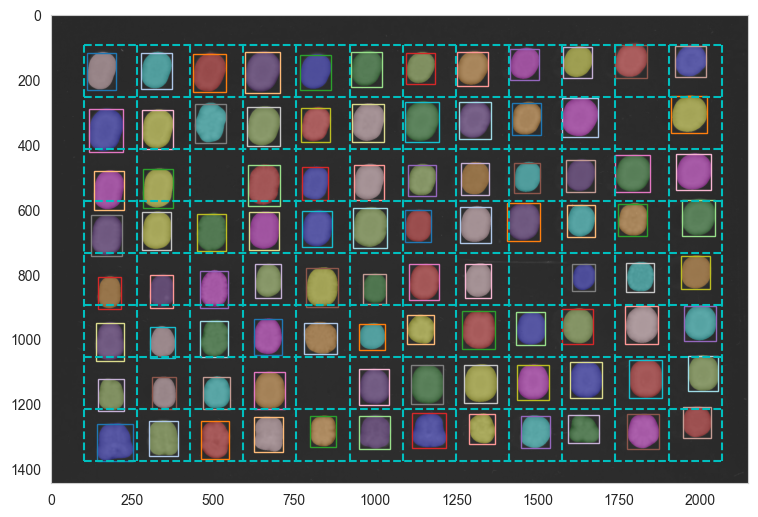

In [9]:
from phenotypic.pipeline import ImagePipeline
from phenotypic.enhancement import CLAHE, GaussianSmoother, MedianEnhancer, ContrastStretching
from phenotypic.detection import WatershedDetector
from phenotypic.grid import GridAligner, GridApply, MinResidualErrorReducer, LinRegResidualOutlierRemover
from phenotypic.objects import BorderObjectRemover, SmallObjectRemover, LowCircularityRemover

from phenotypic.measure import MeasureColor, MeasureShape, MeasureIntensity, MeasureTexture

kmarx_pipeline = ImagePipeline(
    op_queue={
        'blur': GaussianSmoother(sigma=10),
        'clahe': CLAHE(),
        'median filter': MedianEnhancer(),
        'detection': WatershedDetector(footprint='auto')},

    measurement_queue={
        'MeasureColor': MeasureColor(),
        'MeasureShape': MeasureShape(),
        'MeasureIntensity': MeasureIntensity(),
        'MeasureTexture': MeasureTexture()}
)

pipeline_output = kmarx_pipeline.apply(plate_image)
pipeline_output.objects.relabel()
pipeline_output.show_overlay()



(<Figure size 640x480 with 1 Axes>, <Axes: >)

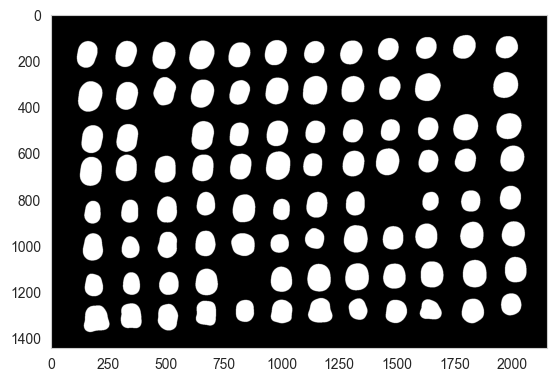

In [10]:
pipeline_output.objmask.show()

In [11]:
from phenotypic.pipeline import ImagePipeline
from phenotypic.enhancement import CLAHE, GaussianSmoother, MedianEnhancer, ContrastStretching
from phenotypic.detection import OtsuDetector
from phenotypic.grid import GridAligner, GridApply, MinResidualErrorReducer, LinRegResidualOutlierRemover
from phenotypic.objects import BorderObjectRemover, SmallObjectRemover, LowCircularityRemover

from phenotypic.measure import MeasureColor, MeasureShape, MeasureIntensity, MeasureTexture

kmarx_pipeline = ImagePipeline(
    op_queue={
        'blur': GaussianSmoother(sigma=10),
        'clahe': CLAHE(),
        'median filter': MedianEnhancer(),
        'detection': OtsuDetector(),
        'border_removal': BorderObjectRemover(50),
        'low circularity remover': LowCircularityRemover(0.6),
        'small object remover': SmallObjectRemover(100),
        'Reduce by section residual error': MinResidualErrorReducer(),
        'outlier removal': LinRegResidualOutlierRemover(),
        'align': GridAligner(),
        'section-level detect': GridApply(ImagePipeline({
            'blur': GaussianSmoother(sigma=5),
            'median filter': MedianEnhancer(),
            'contrast stretching': ContrastStretching(),
            'detection': OtsuDetector(),
        }
        )
        ),
        'small object remover 2': SmallObjectRemover(100),
        'grid_reduction': MinResidualErrorReducer()
    },
    measurement_queue={
        'MeasureColor': MeasureColor(),
        'MeasureShape': MeasureShape(),
        'MeasureIntensity': MeasureIntensity(),
        'MeasureTexture': MeasureTexture()}
)

pipeline_output = kmarx_pipeline.apply(plate_image)
pipeline_output.show_overlay()



KeyboardInterrupt: 

In [12]:
shape_measurements = MeasureShape().measure(pipeline_output)
shape_measurements

,Shape_Area,Shape_Perimeter,Shape_Circularity,Shape_ConvexArea,Shape_MeanRadius,Shape_MedianRadius,Shape_Eccentricity,Shape_Solidity,Shape_Extent,Shape_BboxArea,Shape_MajorAxisLength,Shape_MinorAxisLength
ObjectLabel,,,,,,,,,,,,
1,7988.0,332.149278,0.909874,317.679792,13.587413,11.000000,0.504558,25.144816,0.799120,9996.0,108.573096,93.739611
2,7272.0,316.149278,0.914280,302.796940,12.827662,10.198039,0.475021,24.016095,0.789062,9216.0,102.624626,90.307027
3,6685.0,304.007143,0.908958,290.148037,12.530484,10.198039,0.496210,23.039963,0.799068,8366.0,99.030916,85.978898
4,6765.0,306.249783,0.906413,292.227492,12.357938,9.899495,0.523953,23.149773,0.791784,8544.0,100.581933,85.670376
5,8213.0,338.977705,0.898192,323.033129,13.508715,10.770330,0.565759,25.424637,0.792149,10368.0,112.654492,92.891601
...,...,...,...,...,...,...,...,...,...,...,...,...
88,7422.0,321.421356,0.902779,306.812056,13.151791,10.770330,0.448755,24.190705,0.806739,9200.0,103.027942,92.071413
89,8002.0,339.722871,0.871282,326.060899,14.153611,12.369317,0.579137,24.541428,0.859598,9309.0,112.597343,91.792766
90,8332.0,345.379726,0.877739,331.272715,14.344048,12.165525,0.568524,25.151483,0.865213,9630.0,114.278217,94.012902


In [13]:
intensity_measurements = MeasureIntensity().measure(pipeline_output)
intensity_measurements

,Intensity_IntegratedIntensity
ObjectLabel,
1,3613.796995
2,3203.710938
3,2658.038822
4,2712.523472
5,3367.219164
...,...
88,3228.769015
89,3367.396265
90,3444.188062


In [14]:
texture_measurements = MeasureTexture().measure(pipeline_output)
texture_measurements

,Texture_AngularSecondMoment-deg(0)-intensity-scale(5),Texture_AngularSecondMoment-deg(45)-intensity-scale(5),Texture_AngularSecondMoment-deg(90)-intensity-scale(5),Texture_AngularSecondMoment-deg(135)-intensity-scale(5),Texture_Contrast-deg(0)-intensity-scale(5),Texture_Contrast-deg(45)-intensity-scale(5),Texture_Contrast-deg(90)-intensity-scale(5),Texture_Contrast-deg(135)-intensity-scale(5),Texture_Correlation-deg(0)-intensity-scale(5),Texture_Correlation-deg(45)-intensity-scale(5),...,Texture_DifferenceEntropy-deg(135)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(0)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(45)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(90)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(135)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(0)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(45)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(90)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(135)-intensity-scale(5),Texture_CoefficientVariance-intensity-scale(5)
ObjectLabel,,,,,,,,,,,,,,,,,,,,,
1,0.014014,0.013105,0.014166,0.012988,35.801150,64.889997,32.267005,53.292630,0.855691,0.725193,...,3.872133,-0.275462,-0.217385,-0.272673,-0.217461,0.962632,0.932258,0.961810,0.933102,0.107382
2,0.010636,0.008624,0.010658,0.009385,27.532833,51.342250,30.242491,44.180353,0.804586,0.611970,...,3.725269,-0.230022,-0.149240,-0.212964,-0.151899,0.934846,0.856305,0.923456,0.861605,0.084552
3,0.042984,0.039907,0.043119,0.040924,25.151247,47.360976,27.960256,38.286562,0.776562,0.548771,...,3.452877,-0.269832,-0.183267,-0.241780,-0.184217,0.936590,0.866280,0.920936,0.869404,0.084736
4,0.013180,0.012014,0.013550,0.011963,37.979475,66.734930,36.844146,54.564687,0.765999,0.568254,...,3.755901,-0.237391,-0.157963,-0.215209,-0.155559,0.935649,0.861977,0.921832,0.860794,0.102269
5,0.018715,0.016769,0.019415,0.017204,48.740128,90.820665,46.972071,67.709707,0.813516,0.628809,...,3.891008,-0.284708,-0.189563,-0.258149,-0.194255,0.961144,0.902256,0.950894,0.907909,0.124561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.005020,0.004283,0.005385,0.004416,31.932678,51.872928,31.019822,50.932176,0.840367,0.730029,...,3.877552,-0.256407,-0.178851,-0.238738,-0.172435,0.959813,0.909508,0.952174,0.903489,0.100381
89,0.005204,0.004241,0.004916,0.004285,21.288871,43.300138,29.172441,45.541678,0.867203,0.697735,...,3.828168,-0.256322,-0.184877,-0.230657,-0.178080,0.959144,0.913268,0.946945,0.906899,0.090055
90,0.003543,0.003179,0.004162,0.003070,25.375257,40.160042,24.286657,47.113857,0.815441,0.678948,...,3.821789,-0.219540,-0.153478,-0.226527,-0.147149,0.939734,0.879274,0.944048,0.870516,0.084947


In [15]:
color_measurements =MeasureColor().measure(pipeline_output)
color_measurements

,Hue_Mean,Hue_StdDev,Hue_Median,Hue_CoefficientVariance,Saturation_Mean,Saturation_StdDev,Saturation_Median,Saturation_CoefficientVariance,Brightness_Mean,Brightness_StdDev,Brightness_Median,Brightness_CoefficientVariance
ObjectLabel,,,,,,,,,,,,
1,277.597526,31.272854,281.250000,0.112669,22.770002,4.074599,21.744186,0.178968,124.247997,13.544552,131.0,0.109026
2,276.140732,19.650352,276.923077,0.071170,24.152809,3.784244,25.113636,0.156701,121.715072,10.903729,126.0,0.089596
3,271.899389,45.875779,276.923077,0.168749,23.290197,5.245104,24.181034,0.225240,109.503366,10.734082,115.0,0.098040
4,271.445471,61.397502,283.636364,0.226221,22.975836,5.268058,23.771186,0.229321,110.010939,12.391216,116.0,0.112653
5,267.824188,72.291271,283.636364,0.269953,21.657963,5.146899,22.991803,0.237674,112.014124,15.179403,119.0,0.135530
...,...,...,...,...,...,...,...,...,...,...,...,...
88,289.542428,58.694489,294.545455,0.202742,20.847077,3.318447,21.744186,0.159202,118.196039,12.337479,123.0,0.104396
89,291.641349,91.954215,326.666667,0.315338,22.590933,5.250178,22.804878,0.232431,115.082354,11.596475,118.0,0.100779
90,280.764635,95.786023,310.000000,0.341202,20.562267,4.233801,21.250000,0.205926,112.246039,10.372801,115.0,0.092422


In [16]:
pipeline_measurements = kmarx_pipeline.measure(pipeline_output)

In [17]:
pipeline_measurements

,Hue_Mean,Hue_StdDev,Hue_Median,Hue_CoefficientVariance,Saturation_Mean,Saturation_StdDev,Saturation_Median,Saturation_CoefficientVariance,Brightness_Mean,Brightness_StdDev,...,Texture_DifferenceEntropy-deg(135)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(0)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(45)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(90)-intensity-scale(5),Texture_InformationCorrelation(1)-deg(135)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(0)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(45)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(90)-intensity-scale(5),Texture_InformationCorrelation(2)-deg(135)-intensity-scale(5),Texture_CoefficientVariance-intensity-scale(5)
ObjectLabel,,,,,,,,,,,,,,,,,,,,,
1,277.597526,31.272854,281.250000,0.112669,22.770002,4.074599,21.744186,0.178968,124.247997,13.544552,...,3.872133,-0.275462,-0.217385,-0.272673,-0.217461,0.962632,0.932258,0.961810,0.933102,0.107382
2,276.140732,19.650352,276.923077,0.071170,24.152809,3.784244,25.113636,0.156701,121.715072,10.903729,...,3.725269,-0.230022,-0.149240,-0.212964,-0.151899,0.934846,0.856305,0.923456,0.861605,0.084552
3,271.899389,45.875779,276.923077,0.168749,23.290197,5.245104,24.181034,0.225240,109.503366,10.734082,...,3.452877,-0.269832,-0.183267,-0.241780,-0.184217,0.936590,0.866280,0.920936,0.869404,0.084736
4,271.445471,61.397502,283.636364,0.226221,22.975836,5.268058,23.771186,0.229321,110.010939,12.391216,...,3.755901,-0.237391,-0.157963,-0.215209,-0.155559,0.935649,0.861977,0.921832,0.860794,0.102269
5,267.824188,72.291271,283.636364,0.269953,21.657963,5.146899,22.991803,0.237674,112.014124,15.179403,...,3.891008,-0.284708,-0.189563,-0.258149,-0.194255,0.961144,0.902256,0.950894,0.907909,0.124561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,289.542428,58.694489,294.545455,0.202742,20.847077,3.318447,21.744186,0.159202,118.196039,12.337479,...,3.877552,-0.256407,-0.178851,-0.238738,-0.172435,0.959813,0.909508,0.952174,0.903489,0.100381
89,291.641349,91.954215,326.666667,0.315338,22.590933,5.250178,22.804878,0.232431,115.082354,11.596475,...,3.828168,-0.256322,-0.184877,-0.230657,-0.178080,0.959144,0.913268,0.946945,0.906899,0.090055
90,280.764635,95.786023,310.000000,0.341202,20.562267,4.233801,21.250000,0.205926,112.246039,10.372801,...,3.821789,-0.219540,-0.153478,-0.226527,-0.147149,0.939734,0.879274,0.944048,0.870516,0.084947
